In [1]:
import torch
import numpy as np
from torch import nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

In [2]:
states_in_the_prediction = ['01','02','04','05','06','08','09','10','12','13','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39','40',
 '41','42','44','45','46','47','48','49','50','51','53','54','55','56']

In [157]:
truth_df = pd.read_csv("../data/CDC/truth-Incident Hospitalizations.csv")
truth_df = truth_df[(truth_df['date'] >= '2022-02-26') & (truth_df['date'] < '2023-01-28')]
truth_df = truth_df[truth_df['location'] != 'US']
truth_df = truth_df[truth_df['location'].isin(states_in_the_prediction)]
truth_df.sort_values(by=['date', 'location'], inplace=True)
unique_dates = truth_df['date'].unique()
unique_states = truth_df['location'].unique()

weeks = np.zeros([len(unique_dates),len(unique_states)])
for id1,i in enumerate(unique_dates):
    for id2,j in enumerate(unique_states):
        weeks[id1,id2] = truth_df[(truth_df['date']==i) & (truth_df['location']==j)]['value'].values

In [13]:
# import required module
import os
# assign directory
directory = '../data/GLEAM'
 
# iterate over files in
# that directory
files_name = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        files_name.append(f)
        # print(f)

In [16]:
weeks_1_df = pd.DataFrame()
weeks_2_df = pd.DataFrame()
weeks_3_df = pd.DataFrame()
weeks_4_df = pd.DataFrame()
for i in files_name:
    if i.endswith(".csv"):
        df = pd.read_csv(i)
        # if df['target'] == '1 wk ahead inc flu hosp':
        weeks_1_df = weeks_1_df.append(df[(df['target'] == '1 wk ahead inc flu hosp') & (df['type'] == 'point')])
        weeks_2_df = weeks_2_df.append(df[(df['target'] == '2 wk ahead inc flu hosp') & (df['type'] == 'point')])
        weeks_3_df = weeks_3_df.append(df[(df['target'] == '3 wk ahead inc flu hosp') & (df['type'] == 'point')])
        weeks_4_df = weeks_4_df.append(df[(df['target'] == '4 wk ahead inc flu hosp') & (df['type'] == 'point')])

weeks_1_df = weeks_1_df.drop(['target','type','quantile'],axis = 1)
weeks_2_df = weeks_2_df.drop(['target','type','quantile'],axis = 1)
weeks_3_df = weeks_3_df.drop(['target','type','quantile'],axis = 1)
weeks_4_df = weeks_4_df.drop(['target','type','quantile'],axis = 1)


weeks_1_df = weeks_1_df.sort_values(by=['target_end_date', 'location'])
weeks_2_df = weeks_2_df.sort_values(by=['target_end_date', 'location'])
weeks_3_df = weeks_3_df.sort_values(by=['target_end_date', 'location'])
weeks_4_df = weeks_4_df.sort_values(by=['target_end_date', 'location'])

week1_after_interpolation = pd.read_csv('../data/Flu_Interpolation/week1_after_interpolation.csv')
week2_after_interpolation = pd.read_csv('../data/Flu_Interpolation/week2_after_interpolation.csv')
week3_after_interpolation = pd.read_csv('../data/Flu_Interpolation/week3_after_interpolation.csv')
week4_after_interpolation = pd.read_csv('../data/Flu_Interpolation/week4_after_interpolation.csv')

week1_after_interpolation.rename(columns = {"value_a": "value"}, inplace = True)
week2_after_interpolation.rename(columns = {"value_a": "value"}, inplace = True)
week3_after_interpolation.rename(columns = {"value_a": "value"}, inplace = True)
week4_after_interpolation.rename(columns = {"value_a": "value"}, inplace = True)

temp_merged_week1_df = pd.merge(weeks_1_df, week1_after_interpolation, on=['target_end_date', 'location'], how="outer", validate="one_to_many")[['target_end_date', 'location', 'value_x','value_y']]
temp_merged_week1_df['value_x'] = temp_merged_week1_df['value_x'].fillna(temp_merged_week1_df['value_y'])
weeks_1_df = temp_merged_week1_df.rename(columns = {"value_x": "value"}).sort_values(by=['target_end_date', 'location'])[['target_end_date', 'location', 'value']]

temp_merged_week2_df = pd.merge(weeks_2_df, week2_after_interpolation, on=['target_end_date', 'location'], how="outer", validate="one_to_many")[['target_end_date', 'location', 'value_x','value_y']]
temp_merged_week2_df['value_x'] = temp_merged_week2_df['value_x'].fillna(temp_merged_week2_df['value_y'])
weeks_2_df = temp_merged_week2_df.rename(columns = {"value_x": "value"}).sort_values(by=['target_end_date', 'location'])[['target_end_date', 'location', 'value']]

temp_merged_week3_df = pd.merge(weeks_3_df, week3_after_interpolation, on=['target_end_date', 'location'], how="outer", validate="one_to_many")[['target_end_date', 'location', 'value_x','value_y']]
temp_merged_week3_df['value_x'] = temp_merged_week3_df['value_x'].fillna(temp_merged_week3_df['value_y'])
weeks_3_df = temp_merged_week3_df.rename(columns = {"value_x": "value"}).sort_values(by=['target_end_date', 'location'])[['target_end_date', 'location', 'value']]

temp_merged_week4_df = pd.merge(weeks_4_df, week4_after_interpolation, on=['target_end_date', 'location'], how="outer", validate="one_to_many")[['target_end_date', 'location', 'value_x','value_y']]
temp_merged_week4_df['value_x'] = temp_merged_week4_df['value_x'].fillna(temp_merged_week4_df['value_y'])
weeks_4_df = temp_merged_week4_df.rename(columns = {"value_x": "value"}).sort_values(by=['target_end_date', 'location'])[['target_end_date', 'location', 'value']]


# # weeks to drop
lst_weeks_drop = ['2023-01-28']
# # states to drop 
states_to_drop = ['11','US']

weeks_1_df = weeks_1_df[~weeks_1_df['target_end_date'].isin(lst_weeks_drop)]
weeks_2_df = weeks_2_df[~weeks_2_df['target_end_date'].isin(lst_weeks_drop)]
weeks_3_df = weeks_3_df[~weeks_3_df['target_end_date'].isin(lst_weeks_drop)]
weeks_4_df = weeks_4_df[~weeks_4_df['target_end_date'].isin(lst_weeks_drop)]

weeks_1_df = weeks_1_df[~weeks_1_df['location'].isin(states_to_drop)]
weeks_2_df = weeks_2_df[~weeks_2_df['location'].isin(states_to_drop)]
weeks_3_df = weeks_3_df[~weeks_3_df['location'].isin(states_to_drop)]
weeks_4_df = weeks_4_df[~weeks_4_df['location'].isin(states_to_drop)]


# 1 week ahead
week_1_df_2 = weeks_1_df.drop_duplicates(subset=['target_end_date'])
week_1_df_3 = weeks_1_df.drop_duplicates(subset=['location'])
list1_week1 = list(week_1_df_2['target_end_date'][3:])
list2_week1 = list(week_1_df_3['location'])

# 2 week ahead
week_2_df_2 = weeks_2_df.drop_duplicates(subset=['target_end_date'])
week_2_df_3 = weeks_2_df.drop_duplicates(subset=['location'])
list1_week2 = list(week_2_df_2['target_end_date'][2:-1])
list2_week2 = list(week_2_df_3['location'])

# 3 week ahead
week_3_df_2 = weeks_3_df.drop_duplicates(subset=['target_end_date'])
week_3_df_3 = weeks_3_df.drop_duplicates(subset=['location'])
list1_week3 = list(week_3_df_2['target_end_date'][1:-2])
list2_week3 = list(week_3_df_3['location'])


# 4 week ahead
week_4_df_2 = weeks_4_df.drop_duplicates(subset=['target_end_date'])
week_4_df_3 = weeks_4_df.drop_duplicates(subset=['location'])
list1_week4 = list(week_4_df_2['target_end_date'][:-3])
list2_week4 = list(week_4_df_3['location'])

# Find comman weeks in GLEAM pred
comman_weeks = sorted(list(set.intersection(*map(set, [list1_week1, list1_week2, list1_week3,list1_week4]))))

time_length = len(comman_weeks)
state_length = len(list2_week4)

In [20]:
pred_week1 = np.zeros([time_length,state_length])
no_value_1_week = {}
# for id1,i in enumerate(list1_week1):
for id1,i in enumerate(comman_weeks):
    df4 = weeks_1_df.loc[weeks_1_df['target_end_date'] == i]
    for id2,j in enumerate(list2_week1):
        df5 = df4.loc[df4['location'] == j]
        try:
            pred_week1[id1,id2] = df5['value']
        except:
            # print('error')
            if i not in no_value_1_week.keys():
                no_value_1_week[i] = [j]
            else:
                no_value_1_week[i].append(j)
print(pred_week1.shape)

pred_week2 = np.zeros([time_length,state_length])
no_value_2_week = {}
# for id1,i in enumerate(list1_week2):
for id1,i in enumerate(comman_weeks):
    df4 = weeks_2_df.loc[weeks_2_df['target_end_date'] == i]
    for id2,j in enumerate(list2_week2):
        df5 = df4.loc[df4['location'] == j]
        try:
            pred_week2[id1,id2] = df5['value']
        except:
            # print('error')
            if i not in no_value_2_week.keys():
                no_value_2_week[i] = [j]
            else:
                no_value_2_week[i].append(j)
print(pred_week2.shape)

pred_week3 = np.zeros([time_length,state_length])
no_value_3_week = {}
# for id1,i in enumerate(list1_week3):
for id1,i in enumerate(comman_weeks):
    df4 = weeks_3_df.loc[weeks_3_df['target_end_date'] == i]
    for id2,j in enumerate(list2_week3):
        df5 = df4.loc[df4['location'] == j]
        try:
            pred_week3[id1,id2] = df5['value']
        except:
            # print('error')
            if i not in no_value_3_week.keys():
                no_value_3_week[i] = [j]
            else:
                no_value_3_week[i].append(j)
print(pred_week3.shape)

pred_week4 = np.zeros([time_length,state_length])
no_value_4_week = {}
# for id1,i in enumerate(list1_week4):
for id1,i in enumerate(comman_weeks):
    df4 = weeks_4_df.loc[weeks_4_df['target_end_date'] == i]
    for id2,j in enumerate(list2_week4):
        df5 = df4.loc[df4['location'] == j]
        try:
            pred_week4[id1,id2] = df5['value']
        except:
            # print('error')
            if i not in no_value_4_week.keys():
                no_value_4_week[i] = [j]
            else:
                no_value_4_week[i].append(j)
print(pred_week4.shape)

(48, 50)
(48, 50)
(48, 50)
(48, 50)


In [40]:
residual_week1 = pred_week1 - weeks
residual_week2 = pred_week2 - weeks
residual_week3 = pred_week3 - weeks
residual_week4 = pred_week4 - weeks

In [200]:
# split the data into train and validation sets
loader_temp = residual_week4.copy().transpose(1,0)
train_data = loader_temp.copy() # loader_temp[:,:-2].copy() #train_data = loader_temp[:,:-4].copy()
train_data = np.concatenate([train_data[:,i:i+10] for i in range(0, 39, 1)], axis = 0) # np.concatenate([train_data[:,i:i+10] for i in range(0, 46, 1)], axis = 0)
np.random.shuffle(train_data)
val_data = train_data[:500]
train_data = train_data[500:]
test_data = loader_temp[:,-10:].copy() # test_data = loader_temp[:,-10:].copy()

In [201]:
# convert the numpy arrays to PyTorch tensors
# train_inputs = torch.tensor(train_data[:, :6], dtype=torch.float32)
# train_labels = torch.tensor(train_data[:, 6:], dtype=torch.float32)

# val_inputs = torch.tensor(val_data[:, :6], dtype=torch.float32)
# val_labels = torch.tensor(val_data[:, 6:], dtype=torch.float32)

# test_inputs = torch.tensor(test_data[:, :6], dtype=torch.float32)
# test_labels = torch.tensor(test_data[:, 6:], dtype=torch.float32)

train_inputs = torch.tensor(train_data[:, :9], dtype=torch.float32)
train_labels = torch.tensor(train_data[:, 9:10], dtype=torch.float32) #train_labels = torch.tensor(train_data[:, 6:], dtype=torch.float32)

val_inputs = torch.tensor(val_data[:, :9], dtype=torch.float32)
val_labels = torch.tensor(val_data[:, 9:10], dtype=torch.float32) #val_labels = torch.tensor(val_data[:, 6:], dtype=torch.float32)

test_inputs = torch.tensor(test_data[:,1:], dtype=torch.float32) #test_inputs = torch.tensor(test_data[:, :9], dtype=torch.float32)
test_labels = torch.tensor(test_data[:, 9:10], dtype=torch.float32) # test_labels = torch.tensor(test_data[:, 6:], dtype=torch.float32)

mean = train_inputs.mean()
std = train_inputs.std()

train_inputs = (train_inputs - mean) / std
val_inputs = (val_inputs - mean) / std
train_labels = (train_labels - mean) / std
val_labels = (val_labels - mean) / std
test_inputs = (test_inputs  - mean) / std

In [202]:
# create the datasets
train_dataset = torch.utils.data.TensorDataset(train_inputs, train_labels)
val_dataset =torch.utils.data.TensorDataset(val_inputs, val_labels)

# create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=8, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle = False)

In [194]:
# import pickle
# # save
# with open('../data/shuffled_data/MLP_flu_train.pickle', 'wb') as handle:
#     pickle.dump(train_dataset, handle)
# with open('../data/shuffled_data/MLP_flu_val.pickle', 'wb') as handle:
#     pickle.dump(val_dataset, handle)

MLP on residual

In [195]:
class AutoMLP(nn.Module):
    def __init__(self,input_length, output_length,hidden_length):
        super(AutoMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_length, hidden_length),
            nn.ReLU(),
            nn.Linear(hidden_length, hidden_length),
            nn.ReLU(),
            nn.Linear(hidden_length, output_length),
        )
    def forward(self, x):
        return self.model(x)

In [181]:
# class MyMLP(nn.Module):
#     def __init__(self):
#         super(MyMLP, self).__init__()
#         self.input_length = 1 * 50 * 5  # the input shape is (batch_size, num_channels, height, width)
#         self.output_length = 4 * 50 * 1  # the output shape is (batch_size, num_classes, height, width)
#         self.hidden_length = 100  # the number of hidden units in each hidden layer

#         # create the MLP using the AutoMLP class
#         self.model = AutoMLP(self.input_length, self.output_length, self.hidden_length)

#     def forward(self, x):
#         # flatten the input tensor to have shape (batch_size, input_length)
#         x = x.view(x.size(0), -1)
#         # pass the flattened input tensor through the MLP
#         x = self.model(x)
#         # reshape the output tensor to have shape (batch_size, num_classes, height, width)
#         x = x.view(x.size(0), 4, 50, 1)
#         return x

In [142]:
result_dict_1 = {}
week_1_pred_dict = {}
for length in [8,16,32,64,128,256]:
    for lrate in [0.01,0.001,0.0001]:
        model = AutoMLP(9, 1, length).to(device) # 8, 16, 32, 64, 128, 256 model = AutoMLP(6, 4, 256).to(device) # 8, 16, 32, 64, 128, 256
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lrate) #optimizer = optim.Adam(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 10, gamma=0.9) # stepwise learning rate decay
        best_val = 1e6
        for epoch in range(300):
            running_loss = []
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss.append(loss.item())
            # validate the model after each epoch
            model.eval()
            with torch.no_grad():
                val_running_loss = []
                for i, data in enumerate(val_loader, 0):
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_running_loss.append(loss.item())
            if epoch % 10 == 0:
                print('Epoch %d Training loss: %.3f Validation loss : %.3f' % (epoch + 1, np.mean(running_loss),  np.mean(val_running_loss)))
            scheduler.step()
            if np.mean(val_running_loss) < best_val:
                best_val = np.mean(val_running_loss)
                best_model = model

        test_pred_1 = best_model(test_inputs.to(device)) * std + mean
        # result_dict_1[(length,lrate)] = torch.mean(torch.abs(test_pred_1.cpu() - test_labels))
        flat_list = [item for sublist in test_pred_1.detach().numpy() for item in sublist]
        week_1_pred = np.abs(flat_list)
        week_1_pred_dict[(length,lrate)] = week_1_pred
        # result_dict_1[(length,lrate)] = np.mean(np.abs(week_1_pred - test_labels[:,np.array([True, False,])]))
    # print(result_dict_1)

Epoch 1 Training loss: 1.484 Validation loss : 0.880
Epoch 11 Training loss: 0.966 Validation loss : 1.014
Epoch 21 Training loss: 0.626 Validation loss : 1.078
Epoch 31 Training loss: 0.503 Validation loss : 1.190
Epoch 41 Training loss: 0.505 Validation loss : 0.815
Epoch 51 Training loss: 0.632 Validation loss : 1.067
Epoch 61 Training loss: 0.496 Validation loss : 1.036
Epoch 71 Training loss: 0.465 Validation loss : 1.009
Epoch 81 Training loss: 0.430 Validation loss : 1.197
Epoch 91 Training loss: 0.429 Validation loss : 0.972
Epoch 101 Training loss: 0.445 Validation loss : 0.986
Epoch 111 Training loss: 0.395 Validation loss : 0.960
Epoch 121 Training loss: 0.400 Validation loss : 0.819
Epoch 131 Training loss: 0.389 Validation loss : 0.690
Epoch 141 Training loss: 0.374 Validation loss : 0.754
Epoch 151 Training loss: 0.369 Validation loss : 0.742
Epoch 161 Training loss: 0.356 Validation loss : 0.754
Epoch 171 Training loss: 0.350 Validation loss : 0.795
Epoch 181 Training lo

In [183]:
result_dict_2= {}
week_2_pred_dict = {}
for length in [8,16,32,64,128,256]:
    for lrate in [0.01,0.001,0.0001]:
        model = AutoMLP(9, 1, length).to(device) # 8, 16, 32, 64, 128, 256 model = AutoMLP(6, 4, 256).to(device) # 8, 16, 32, 64, 128, 256
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lrate) #optimizer = optim.Adam(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 10, gamma=0.9) # stepwise learning rate decay
        best_val = 1e6
        for epoch in range(300):
            running_loss = []
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss.append(loss.item())
            # validate the model after each epoch
            model.eval()
            with torch.no_grad():
                val_running_loss = []
                for i, data in enumerate(val_loader, 0):
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_running_loss.append(loss.item())
            if epoch % 10 == 0:
                print('Epoch %d Training loss: %.3f Validation loss : %.3f' % (epoch + 1, np.mean(running_loss),  np.mean(val_running_loss)))
            scheduler.step()
            if np.mean(val_running_loss) < best_val:
                best_val = np.mean(val_running_loss)
                best_model = model

        test_pred_1 = best_model(test_inputs.to(device)) * std + mean
        # result_dict_1[(length,lrate)] = torch.mean(torch.abs(test_pred_1.cpu() - test_labels))
        flat_list = [item for sublist in test_pred_1.detach().numpy() for item in sublist]
        week_2_pred = GLEAM_02_04_pred - flat_list
        week_2_pred_dict[(length,lrate)] = week_2_pred
        result_dict_2[(length,lrate)] = np.mean(np.abs(week_2_pred - groundtruth_0204))
    print(result_dict_2)

Epoch 1 Training loss: 0.912 Validation loss : 1.975
Epoch 11 Training loss: 0.416 Validation loss : 1.421
Epoch 21 Training loss: 0.409 Validation loss : 1.153
Epoch 31 Training loss: 0.327 Validation loss : 1.293
Epoch 41 Training loss: 0.328 Validation loss : 1.257
Epoch 51 Training loss: 0.311 Validation loss : 1.167
Epoch 61 Training loss: 0.328 Validation loss : 1.128
Epoch 71 Training loss: 0.286 Validation loss : 1.349
Epoch 81 Training loss: 0.301 Validation loss : 1.129
Epoch 91 Training loss: 0.260 Validation loss : 1.224
Epoch 101 Training loss: 0.277 Validation loss : 1.222
Epoch 111 Training loss: 0.267 Validation loss : 1.235
Epoch 121 Training loss: 0.269 Validation loss : 1.198
Epoch 131 Training loss: 0.252 Validation loss : 1.181
Epoch 141 Training loss: 0.244 Validation loss : 1.186
Epoch 151 Training loss: 0.245 Validation loss : 1.197
Epoch 161 Training loss: 0.248 Validation loss : 1.170
Epoch 171 Training loss: 0.240 Validation loss : 1.130
Epoch 181 Training lo

In [197]:
groundtruth_0211 = np.array([ 32,   2,  51,  36,  92,  24,  14,   1, 277,  51,  10,   4,  33,
        37,  15,  10,  31,  55,   7,  36,  63,  51,   9,  19,  39,   4,
         0,  10,   9,  27,   9, 101,  54,  19,  46,  52,   6, 175,   1,
        47,   9,  36, 276,   6,   0,  63,  42,  16,  23,   2])
groundtruth_0218 = np.array([ 29,   5,  35,  24,  80,  17,  16,   1, 216,  44,   4,   8,  26,
        35,   9,   4,  20,  28,   5,  25,  30,  57,   8,  30,  45,   3,
         5,  19,   4,  57,   3,  86,  43,  10,  40,  42,   4, 188,   2,
        42,  10,  48, 232,   4,   2,  54,  40,  10,   5,   1])

In [198]:
result_dict_3= {}
week_3_pred_dict = {}
for length in [8,16,32,64,128,256]:
    for lrate in [0.01,0.001,0.0001]:
        model = AutoMLP(9, 1, length).to(device) # 8, 16, 32, 64, 128, 256 model = AutoMLP(6, 4, 256).to(device) # 8, 16, 32, 64, 128, 256
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lrate) #optimizer = optim.Adam(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 10, gamma=0.9) # stepwise learning rate decay
        best_val = 1e6
        for epoch in range(300):
            running_loss = []
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss.append(loss.item())
            # validate the model after each epoch
            model.eval()
            with torch.no_grad():
                val_running_loss = []
                for i, data in enumerate(val_loader, 0):
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_running_loss.append(loss.item())
            if epoch % 10 == 0:
                print('Epoch %d Training loss: %.3f Validation loss : %.3f' % (epoch + 1, np.mean(running_loss),  np.mean(val_running_loss)))
            scheduler.step()
            if np.mean(val_running_loss) < best_val:
                best_val = np.mean(val_running_loss)
                best_model = model

        test_pred_1 = best_model(test_inputs.to(device)) * std + mean
        # result_dict_1[(length,lrate)] = torch.mean(torch.abs(test_pred_1.cpu() - test_labels))
        flat_list = [item for sublist in test_pred_1.detach().numpy() for item in sublist]
        week_3_pred = GLEAM_02_11_pred - flat_list
        week_3_pred_dict[(length,lrate)] = week_3_pred
        result_dict_3[(length,lrate)] = np.mean(np.abs(week_3_pred - groundtruth_0211))
    print(result_dict_3)

Epoch 1 Training loss: 1.091 Validation loss : 0.970
Epoch 11 Training loss: 0.777 Validation loss : 0.483
Epoch 21 Training loss: 0.405 Validation loss : 0.565
Epoch 31 Training loss: 0.372 Validation loss : 0.366
Epoch 41 Training loss: 0.366 Validation loss : 0.326
Epoch 51 Training loss: 0.318 Validation loss : 0.335
Epoch 61 Training loss: 0.374 Validation loss : 0.398
Epoch 71 Training loss: 0.284 Validation loss : 0.427
Epoch 81 Training loss: 0.297 Validation loss : 0.420
Epoch 91 Training loss: 0.289 Validation loss : 0.462
Epoch 101 Training loss: 0.253 Validation loss : 0.521
Epoch 111 Training loss: 0.274 Validation loss : 0.475
Epoch 121 Training loss: 0.231 Validation loss : 0.490
Epoch 131 Training loss: 0.251 Validation loss : 0.502
Epoch 141 Training loss: 0.233 Validation loss : 0.550
Epoch 151 Training loss: 0.217 Validation loss : 0.568
Epoch 161 Training loss: 0.218 Validation loss : 0.625
Epoch 171 Training loss: 0.219 Validation loss : 0.592
Epoch 181 Training lo

In [199]:
result_dict_3

{(8, 0.01): 70.79405978863882,
 (8, 0.001): 108.77403125014119,
 (8, 0.0001): 99.25393051276951,
 (16, 0.01): 122.33531548203932,
 (16, 0.001): 159.75634317861724,
 (16, 0.0001): 94.72995295668402,
 (32, 0.01): 119.60221901741372,
 (32, 0.001): 137.37684196977264,
 (32, 0.0001): 126.14890257598557,
 (64, 0.01): 46.62344128979822,
 (64, 0.001): 88.82220923434741,
 (64, 0.0001): 106.44720839849276,
 (128, 0.01): 110.93477116383038,
 (128, 0.001): 87.22838662586247,
 (128, 0.0001): 124.40957542774339,
 (256, 0.01): 250.1408777314121,
 (256, 0.001): 105.22851719834514,
 (256, 0.0001): 185.72822242979942}

In [203]:
result_dict_4= {}
week_4_pred_dict = {}
for length in [8,16,32,64,128,256]:
    for lrate in [0.01,0.001,0.0001]:
        model = AutoMLP(9, 1, length).to(device) # 8, 16, 32, 64, 128, 256 model = AutoMLP(6, 4, 256).to(device) # 8, 16, 32, 64, 128, 256
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lrate) #optimizer = optim.Adam(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 10, gamma=0.9) # stepwise learning rate decay
        best_val = 1e6
        for epoch in range(300):
            running_loss = []
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss.append(loss.item())
            # validate the model after each epoch
            model.eval()
            with torch.no_grad():
                val_running_loss = []
                for i, data in enumerate(val_loader, 0):
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_running_loss.append(loss.item())
            if epoch % 10 == 0:
                print('Epoch %d Training loss: %.3f Validation loss : %.3f' % (epoch + 1, np.mean(running_loss),  np.mean(val_running_loss)))
            scheduler.step()
            if np.mean(val_running_loss) < best_val:
                best_val = np.mean(val_running_loss)
                best_model = model

        test_pred_1 = best_model(test_inputs.to(device)) * std + mean
        # result_dict_1[(length,lrate)] = torch.mean(torch.abs(test_pred_1.cpu() - test_labels))
        flat_list = [item for sublist in test_pred_1.detach().numpy() for item in sublist]
        week_4_pred = GLEAM_02_18_pred - flat_list
        week_4_pred_dict[(length,lrate)] = week_4_pred
        result_dict_4[(length,lrate)] = np.mean(np.abs(week_4_pred - groundtruth_0218))
    print(result_dict_4)

Epoch 1 Training loss: 0.753 Validation loss : 0.304
Epoch 11 Training loss: 0.427 Validation loss : 0.300
Epoch 21 Training loss: 0.417 Validation loss : 0.279
Epoch 31 Training loss: 0.314 Validation loss : 0.350
Epoch 41 Training loss: 0.282 Validation loss : 0.240
Epoch 51 Training loss: 0.296 Validation loss : 0.246
Epoch 61 Training loss: 0.250 Validation loss : 0.226
Epoch 71 Training loss: 0.236 Validation loss : 0.248
Epoch 81 Training loss: 0.284 Validation loss : 0.258
Epoch 91 Training loss: 0.231 Validation loss : 0.295
Epoch 101 Training loss: 0.225 Validation loss : 0.227
Epoch 111 Training loss: 0.227 Validation loss : 0.223
Epoch 121 Training loss: 0.219 Validation loss : 0.259
Epoch 131 Training loss: 0.214 Validation loss : 0.228
Epoch 141 Training loss: 0.202 Validation loss : 0.265
Epoch 151 Training loss: 0.210 Validation loss : 0.268
Epoch 161 Training loss: 0.198 Validation loss : 0.299
Epoch 171 Training loss: 0.192 Validation loss : 0.284
Epoch 181 Training lo

In [204]:
result_dict_4

{(8, 0.01): 57.33877815613555,
 (8, 0.001): 59.41888055489552,
 (8, 0.0001): 41.23653542500978,
 (16, 0.01): 36.785781945946994,
 (16, 0.001): 54.66829402249956,
 (16, 0.0001): 57.63096919051698,
 (32, 0.01): 43.536612772017214,
 (32, 0.001): 54.58269059469554,
 (32, 0.0001): 68.29820023973043,
 (64, 0.01): 50.77917589468704,
 (64, 0.001): 61.96634024254757,
 (64, 0.0001): 46.74316556738979,
 (128, 0.01): 49.39484123485132,
 (128, 0.001): 47.89934279533339,
 (128, 0.0001): 41.07442507000591,
 (256, 0.01): 73.41084505666892,
 (256, 0.001): 39.72365351642441,
 (256, 0.0001): 40.27415475591206}

In [189]:
week_2_pred_dict[(128, 0.01)]

array([ 36.06334046,   7.46487664,  52.96629674,  16.91505406,
       157.7189673 ,  39.70065495,  17.48642889,  54.98519633,
       361.37044083,  60.75673356,   7.43937664,  12.51926474,
        41.60776113,  44.12715775,  26.60700726,  20.4196207 ,
        14.77436459,  50.65584854,  18.03051197,  34.81075024,
        74.41281765, 103.44031623,  23.17111682,  31.67156583,
        53.67287527,  12.71272557,  35.98656632,  12.9713623 ,
        17.25621875,  57.78679234,  15.93183471, 131.95944722,
        57.87662034,  16.16782313,  57.40026362,  25.97577047,
        20.79990328, 133.08027514,  13.0823222 ,  39.96599128,
        16.59437405,  48.53252086, 233.43872969,  17.4551058 ,
        12.48533172,  62.92237136,  59.59864455,  12.18353051,
        53.30590929,   6.8338207 ])

In [185]:
result_dict_2

{(8, 0.01): 71.37413064343873,
 (8, 0.001): 64.20534367054866,
 (8, 0.0001): 89.29166615275852,
 (16, 0.01): 43.505100283743076,
 (16, 0.001): 66.94634389784899,
 (16, 0.0001): 73.33122993856372,
 (32, 0.01): 89.30615311983883,
 (32, 0.001): 63.471190360025766,
 (32, 0.0001): 61.761234979717926,
 (64, 0.01): 76.88429925416868,
 (64, 0.001): 117.16233774657807,
 (64, 0.0001): 52.750307172141845,
 (128, 0.01): 16.953055089933528,
 (128, 0.001): 116.39839454779532,
 (128, 0.0001): 57.03439805226869,
 (256, 0.01): 21.407608880170983,
 (256, 0.001): 90.66158904438282,
 (256, 0.0001): 62.459059134451174}

In [184]:
pred = []
for key, value in week_1_pred_dict.items():
    temp_pred = GLEAM_01_28_pred - value
    pred.append(temp_pred)
for i in pred:
    print(np.mean(np.abs(i - groundtruth_0128)))

35.099967062160715
50.411245879216786
23.23556331541947
41.22509817639922
54.759858135501226
20.771377765770705
33.445832867926356
96.06790229497143
28.972138144188467
32.51298369625498
42.06328622766942
39.91557655289826
25.516907304334904
72.50148087913156
34.23674664398589
19.64119910324457
38.67024753623793
55.12449782099018


In [11]:
# model = AutoMLP(6, 4, 256).to(device) # 8, 16, 32, 64, 128, 256
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 10, gamma=0.9) # stepwise learning rate decay

In [78]:
# best_val = 1e6
# for epoch in range(300):
#     running_loss = []
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss.append(loss.item())

    
#     # validate the model after each epoch
#     model.eval()
#     with torch.no_grad():
#         val_running_loss = []
#         for i, data in enumerate(val_loader, 0):
#             inputs, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             val_running_loss.append(loss.item())
#     if epoch % 10 == 0:
#         print('Epoch %d Training loss: %.3f Validation loss : %.3f' % (epoch + 1, np.mean(running_loss),  np.mean(val_running_loss)))
#     scheduler.step()
#     if np.mean(val_running_loss) < best_val:
#         best_val = np.mean(val_running_loss)
#         best_model = model

In [20]:
# tryput_1 = (best_model(test_inputs.to(device))* std + mean)
# np.mean(np.abs(np.abs([item for sublist in tryput_1.detach().numpy() for item in sublist]) - np.array(truth_df[truth_df['date'] == '2023-01-28']['value'])))

In [94]:
# pred = best_model(test_inputs.to(device))[:,np.array([False, False, False,True,])]
# result = []
# for i in range(len(pred)):
#     result.append(((pred[i] * std_arr[i])+ mean_arr[i]).tolist())
# flat_list = [item for sublist in result for item in sublist]
# p.mean(np.abs(flat_list - np.array(truth_df[truth_df['date'] == '2023-02-04']['value'])))

In [13]:
test_preds = best_model(test_inputs.to(device)) * std + mean
# test_preds = best_model(test_inputs.to(device)) * std + mean
# print("test error:", torch.mean(torch.abs(test_preds.cpu() - test_labels)))

temp = test_preds[:,np.array([True, False, False,False,])]
flat_list = [item for sublist in temp.detach().numpy() for item in sublist]
week_1_pred = np.abs(flat_list)

temp = test_preds[:,np.array([False, True, False,False,])]
flat_list = [item for sublist in temp.detach().numpy() for item in sublist]
week_2_pred = np.abs(flat_list)

temp = test_preds[:,np.array([False, False, True,False,])]
flat_list = [item for sublist in temp.detach().numpy() for item in sublist]
week_3_pred = np.abs(flat_list)


temp = test_preds[:,np.array([False, False, False,True,])]
flat_list = [item for sublist in temp.detach().numpy() for item in sublist]
week_4_pred = np.abs(flat_list)

In [163]:
truth_df = pd.read_csv("../data/CDC/truth-Incident Hospitalizations.csv")
# truth_df = truth_df[(truth_df['date'] >= '2022-02-26') & (truth_df['date'] < '2023-01-28')]
truth_df = truth_df[truth_df['location'] != 'US']
truth_df = truth_df[truth_df['location'].isin(states_in_the_prediction)]
truth_df.sort_values(by=['date', 'location'], inplace=True)
groundtruth_0128 = np.array(truth_df[truth_df['date'] == '2023-01-28']['value'])
groundtruth_0204 = np.array(truth_df[truth_df['date'] == '2023-02-04']['value'])

In [164]:
groundtruth_0128

array([ 42,   3,  48,  30, 115,  30,  32,   5, 359,  68,  11,  17,  61,
        66,  45,  17,  29,  42,  11,  37,  71,  86,  15,  30,  68,  10,
        22,  11,  20,  70,  17, 154,  35,  22,  67,  96,  10, 138,  10,
        34,  16,  38, 329,   5,   6,  53,  56,  19,  44,   5])

In [15]:
np.stack([groundtruth_0128,groundtruth_0204])[:,0]

array([42, 34])

In [16]:
print('1 week ahead: ',np.mean(np.abs(week_1_pred - groundtruth_0128)))
print('2 week ahead: ',np.mean(np.abs(week_2_pred - groundtruth_0204)))
print('3 week ahead: ',np.mean(np.abs(week_3_pred - groundtruth_0128)))
print('4 week ahead: ',np.mean(np.abs(week_4_pred - groundtruth_0204)))

1 week ahead:  21.5026469039917
2 week ahead:  22.64774673461914
3 week ahead:  29.41070137023926
4 week ahead:  43.41663303375244


In [196]:
GLEAM_01_23_pd = pd.read_csv("../data/GLEAM/2023-01-23-MOBS-GLEAM_FLUH.csv")
GLEAM_01_28_pred = GLEAM_01_23_pd[(GLEAM_01_23_pd['target'] == '1 wk ahead inc flu hosp') & (GLEAM_01_23_pd['quantile'] == 0.5) & (GLEAM_01_23_pd['location'].isin(states_in_the_prediction))][['location','value']]['value'].to_numpy()
GLEAM_02_04_pred = GLEAM_01_23_pd[(GLEAM_01_23_pd['target'] == '2 wk ahead inc flu hosp') & (GLEAM_01_23_pd['quantile'] == 0.5) & (GLEAM_01_23_pd['location'].isin(states_in_the_prediction))][['location','value']]['value'].to_numpy()
GLEAM_02_11_pred = GLEAM_01_23_pd[(GLEAM_01_23_pd['target'] == '3 wk ahead inc flu hosp') & (GLEAM_01_23_pd['quantile'] == 0.5) & (GLEAM_01_23_pd['location'].isin(states_in_the_prediction))][['location','value']]['value'].to_numpy()
GLEAM_02_18_pred = GLEAM_01_23_pd[(GLEAM_01_23_pd['target'] == '4 wk ahead inc flu hosp') & (GLEAM_01_23_pd['quantile'] == 0.5) & (GLEAM_01_23_pd['location'].isin(states_in_the_prediction))][['location','value']]['value'].to_numpy()

In [91]:
def plot():
    x = np.arange(1,5)
    for i in range(50):
        plt.plot(np.arange(1,3), np.abs(test_preds[i,:].detach().numpy())[:2],label="Prediction", marker = "*")
        plt.plot(np.arange(1,3), np.stack([GLEAM_01_28_pred,GLEAM_02_04_pred])[:,i],label="GLEAM Prediction", marker = "v")
        plt.plot(np.arange(1,3), np.abs(test_preds[i,:].detach().numpy())[2:],label="Prediction Shifted", marker = "*")
        # plt.plot(x, week_4_pred[i],label="Truth Used for Prediction", marker = ".")
        plt.plot(np.arange(1,3),np.stack([groundtruth_0128,groundtruth_0204])[:,i],label="Truth", marker = "o")
        plt.title(states_in_the_prediction[i])
        plt.xlabel("Num of Weeks Ahead")
        plt.ylabel("Number of Flu Cases")
        plt.legend(loc='best')
        # plt.fill_between(x, pred_reshaped[i,:,0] + ground_truth[i,:],pred_reshaped[i,:,2] + ground_truth[i,:],color = 'green',alpha = 0.2)
        #plt.fill_between(x, pred_reshaped[i,:,0]  + ground_truth[i,:],pred_reshaped[i,:,2]  + ground_truth[i,:],color = 'green',alpha = 0.2)
        plt.show()

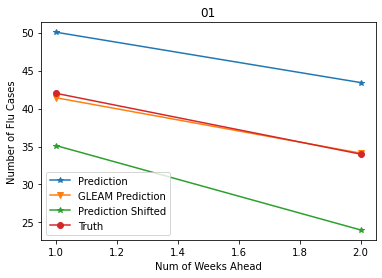

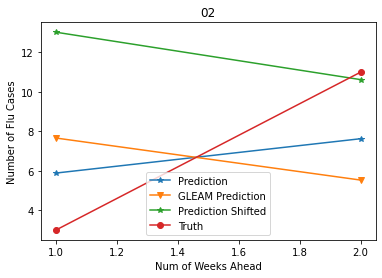

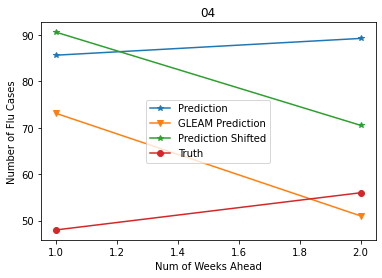

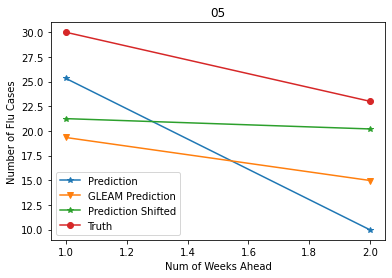

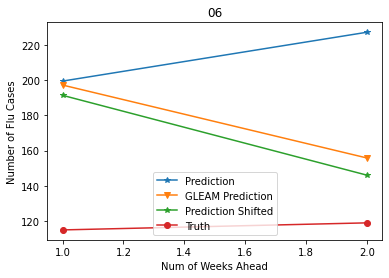

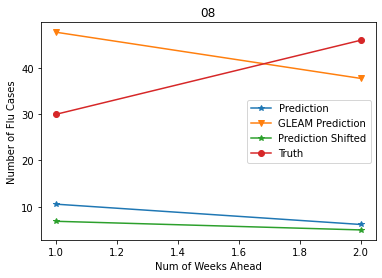

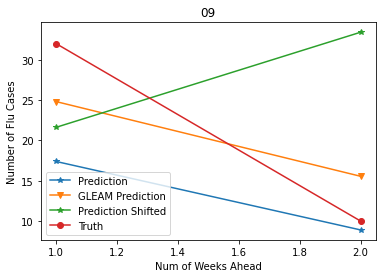

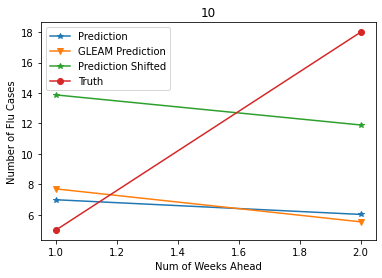

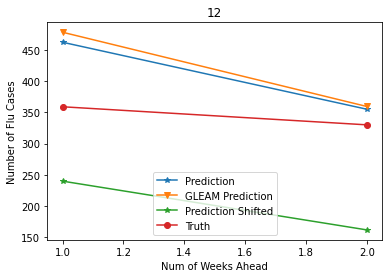

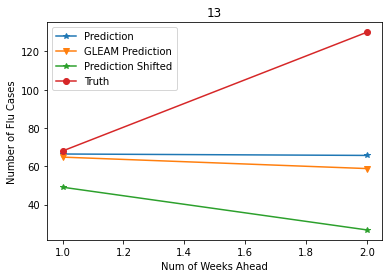

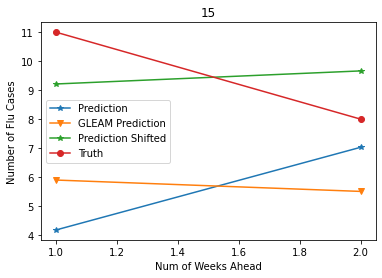

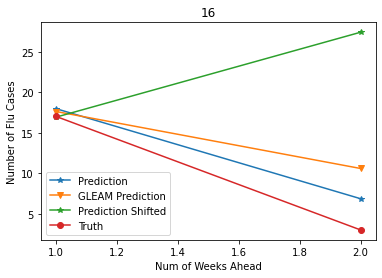

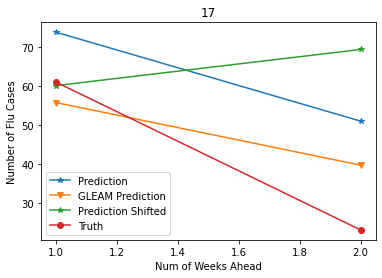

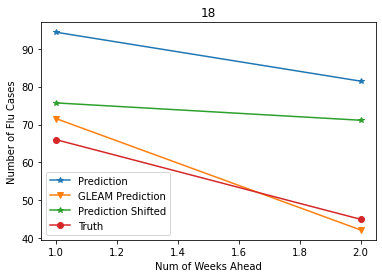

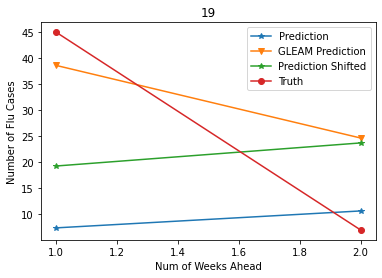

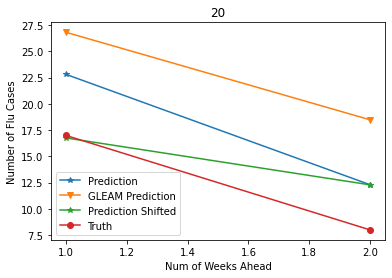

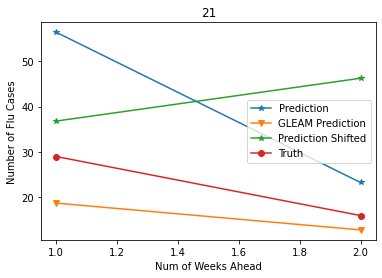

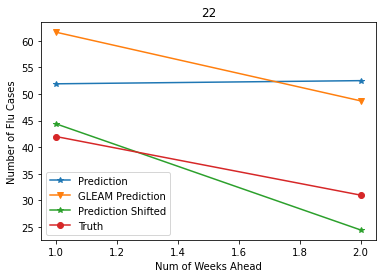

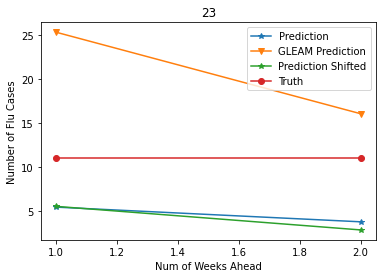

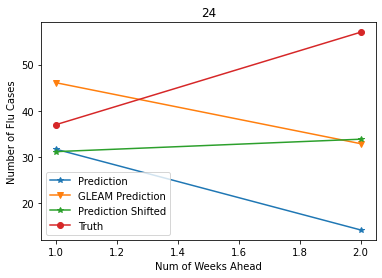

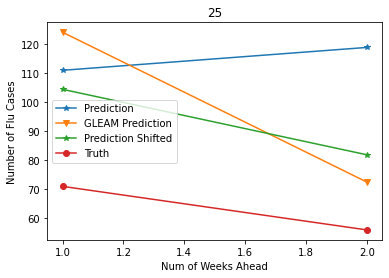

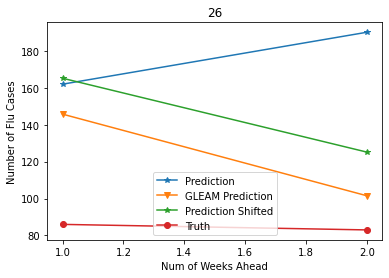

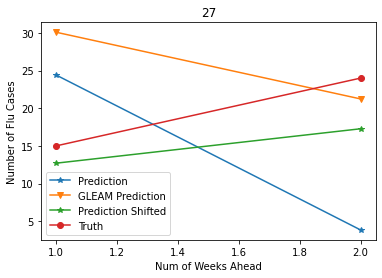

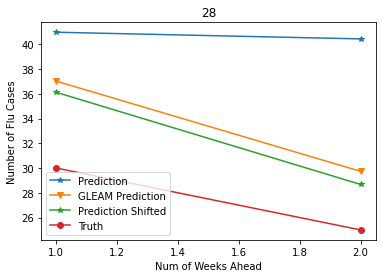

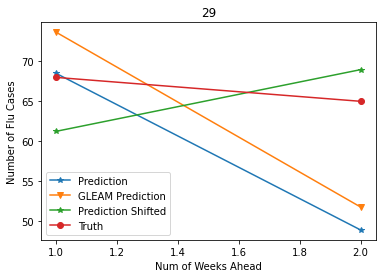

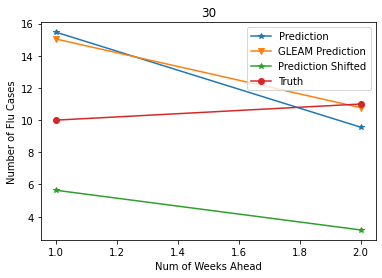

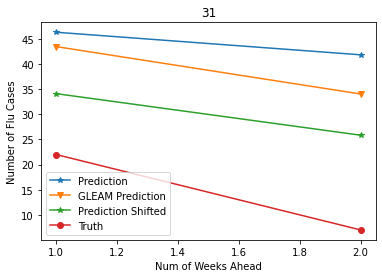

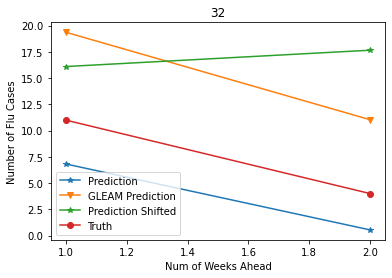

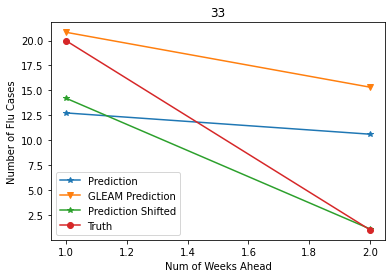

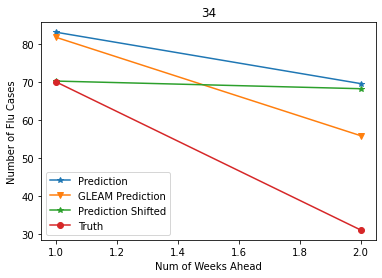

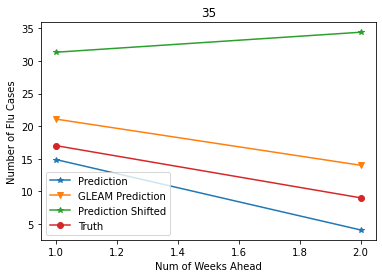

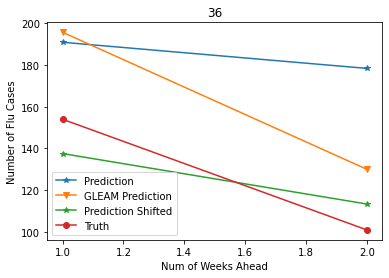

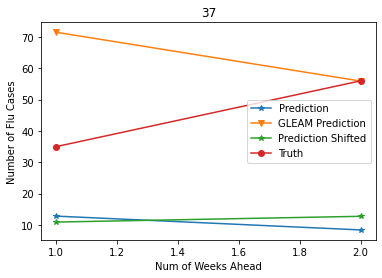

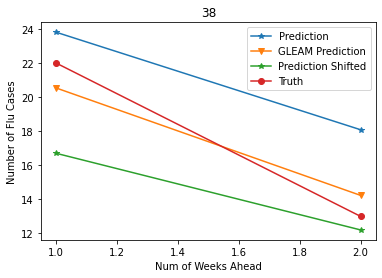

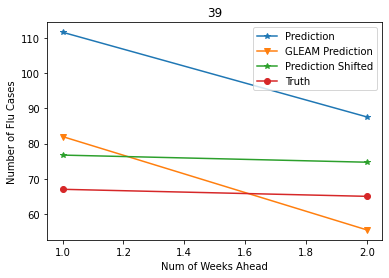

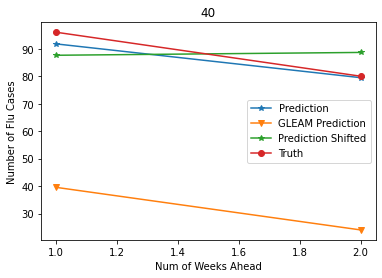

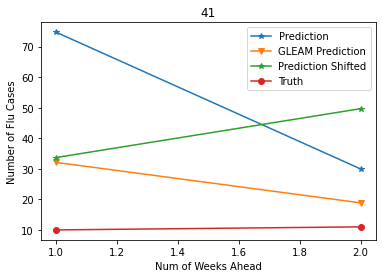

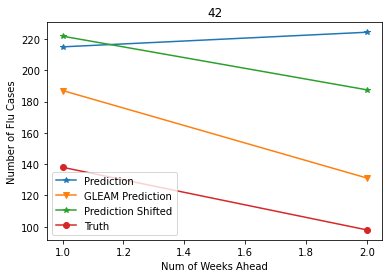

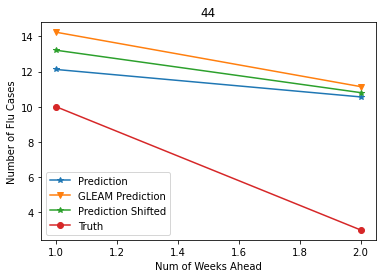

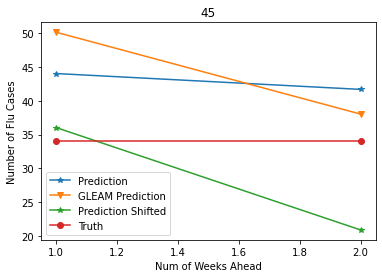

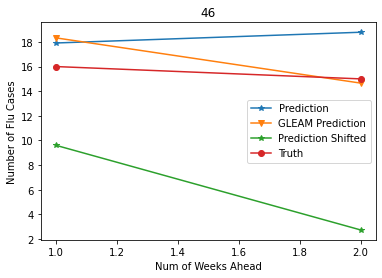

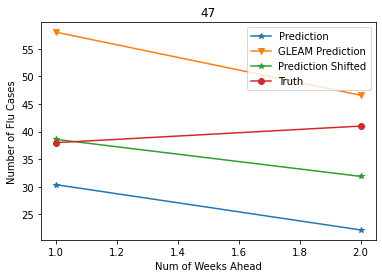

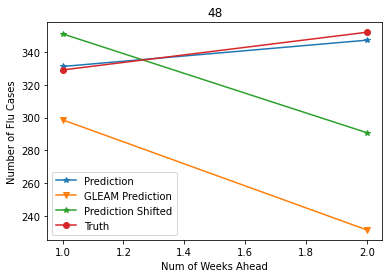

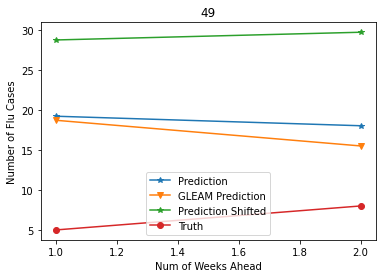

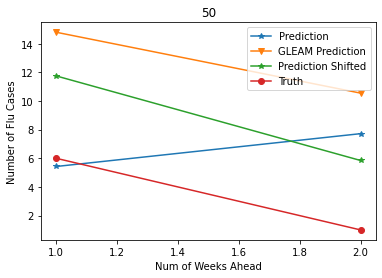

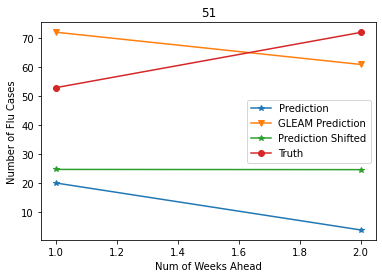

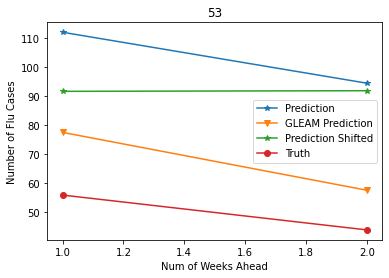

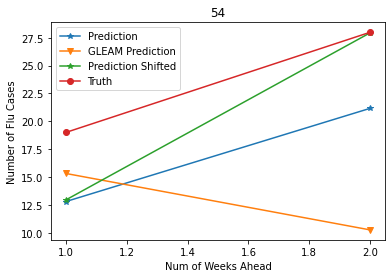

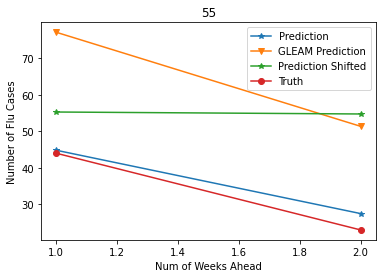

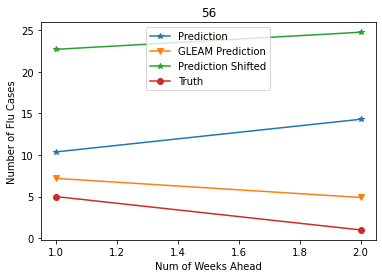

In [92]:
plot()

In [144]:
# proportions = [.90, .10]
# lengths = [int(p * len(train_loader)) for p in proportions]
# lengths[-1] = len(train_loader) - sum(lengths[:-1])
# tr_dataset, vl_dataset = torch.utils.data.random_split(train_loader, lengths)

In [ ]:
# class AutoMLP(nn.Module):
#     def __init__(self,input_length, hidden_length, output_length):
#         super(AutoMLP, self).__init__()
#         self.input_length = input_length
#         self.hidden_length = hidden_length
#         self.output_length = output_length
#         self.fc1 = nn.Linear(self.input_length, self.hidden_length)
#         self.fc2 = nn.Linear(self.hidden_length, self.output_length)
#         self.relu = nn.ReLU()
#         self.softmax = nn.Softmax(dim=1)

In [ ]:
def get_plots_quantile_prediction(npz_file_location):
    npz = np.load(npz_file_location)
    pred = npz['prediction']
    
    # truth = npz['truth']
    ground_truth = np.resize(dfg_date_filtered_truth_filtered[dfg_date_filtered_truth_filtered['date'] == '2023-01-21']['value'].to_numpy(), (4,50)).T

    # print(pred.shape,truth.shape)
    # if "quantile_model" in npz_file_location:
    #     pred_reshaped = pred.reshape(50, 4 ,3)
    #     truth_reshaped = truth.reshape(50, 4)
    # elif "dropout_model" in npz_file_location:
    #     pred_reshaped = pred.reshape(50, 4)
    #     truth_reshaped = truth.reshape(50, 4)
    pred_reshaped = pred.reshape(50, 4 ,3)
    pred_actual_ground_truth = np.resize(dfg_date_filtered_truth_filtered[dfg_date_filtered_truth_filtered['date'].isin(pd.date_range('2023-01-21', '2023-01-28', freq='W-SAT'))]['value'].to_numpy(), (4,50)).T
    # truth_reshaped = truth.reshape(50, 4)

    x = np.arange(1,5)
    # states = list(states_data[1])
    states = dfg_date_filtered_truth_filtered['location_name'].unique()
    # states = states_in_the_prediction
    for i in range(50):
        plt.plot(x, pred_reshaped[i,:,1] + ground_truth[i,:],label="Prediction", marker = "*")
        plt.plot(x, pred_reshaped[i,:,0]  + ground_truth[i,:],label="Lower Bound", marker = "v")
        plt.plot(x, pred_reshaped[i,:,2]  + ground_truth[i,:],label="Upper Bound", marker = "^")
        plt.plot(x, ground_truth[i,:],label="Truth Used for Prediction", marker = ".")
        plt.plot(np.arange(1,3), pred_actual_ground_truth[i,:2],label="Truth", marker = "o")
        plt.title(states[i])
        plt.xlabel("Num of Weeks Ahead")
        plt.ylabel("Number of Flu Cases")
        plt.legend(loc='best')
        # plt.fill_between(x, pred_reshaped[i,:,0] + ground_truth[i,:],pred_reshaped[i,:,2] + ground_truth[i,:],color = 'green',alpha = 0.2)
        plt.fill_between(x, pred_reshaped[i,:,0]  + ground_truth[i,:],pred_reshaped[i,:,2]  + ground_truth[i,:],color = 'green',alpha = 0.2)
        plt.show()